# Best Place for an Asian Restaurant in Lasing Capital Area

##  Introduction/Business Problem


The client is looking to open an Asian restaurant in Lansing Capital Area (Lansing, East Lansing, Okemos, Haslett, Mason, and Holt), MI. 
The location is very important to him as he needs the location of the restaurant fulfills the following considerations:
+ In which region, the most favorite restaurant is an Asian restaurant.
+ The population in the region should not be too small.

In this project, we are interested in restaurants. 
We will use the popularity of the restaurant and population in this zip code region to cluster the venues. 

##   Data source
 
+ All Americal's zipcode data can be found on the website: https://simplemaps.com/data/us-zips.
+ The website of https://www.zipdatamaps.com/{zipcode} provide more details information for each zip code region.
+ With the zipcode of each region, we can use Foursquare to locate venues in each zipcode region. 
Then we will analyze the venues with venue category related to the restaurant.
Using popularity of the restaurant and population in the region to cluster these venues by machine learning method.

#### Load modules

In [ ]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium # map rendering library
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import json # library to handle JSON files
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Get data and clean data

Get geospatial information of Lansing Capital Area. 

In [2]:
path='uszipsv1.4.csv'
gosdf = pd.read_csv(path)
gosdf.head()

,zip,lat,lng,city,state_id,state_name,zcta,parent_zcta,population,county_fips,county_name,all_county_weights,imprecise,military
0,501,40.8133,-73.0476,Holtsville,NY,New York,False,11742.0,NaN,NaN,NaN,NaN,True,False
1,544,40.8133,-73.0476,Holtsville,NY,New York,False,11742.0,NaN,NaN,NaN,NaN,True,False
2,601,18.1800,-66.7522,Adjuntas,PR,Puerto Rico,True,NaN,18570.0,72001.0,72001.0,"{'72001':99.43,'72141':0.57}",False,False
3,602,18.3607,-67.1752,Aguada,PR,Puerto Rico,True,NaN,41520.0,72003.0,72003.0,{'72003':100},False,False
4,603,18.4544,-67.1220,Aguadilla,PR,Puerto Rico,True,NaN,54689.0,72005.0,72005.0,{'72005':100},False,False


In [3]:
GreatLansing = gosdf[(gosdf['city'] == 'Lansing') | (gosdf['city'] == 'Okemos') | (gosdf['city'] == 'East Lansing')|(gosdf['city'] == 'Haslett')|(gosdf['city'] == 'Mason')|(gosdf['city'] == 'Holt')]
LansingMI = GreatLansing[GreatLansing['state_id'] =='MI']
LansingMI.head()

,zip,lat,lng,city,state_id,state_name,zcta,parent_zcta,population,county_fips,county_name,all_county_weights,imprecise,military
20914,48805,42.7082,-84.4144,Okemos,MI,Michigan,False,48864.0,NaN,NaN,NaN,NaN,True,False
20930,48823,42.7620,-84.4539,East Lansing,MI,Michigan,True,NaN,51302.0,26065.0,26065.0,"{'26037':14.5,'26065':85.5}",False,False
20931,48824,42.7229,-84.4751,East Lansing,MI,Michigan,False,48825.0,NaN,NaN,NaN,NaN,False,False
20932,48825,42.7270,-84.4809,East Lansing,MI,Michigan,True,NaN,12596.0,26065.0,26065.0,{'26065':100},False,False
20933,48826,42.7360,-84.4843,East Lansing,MI,Michigan,False,48823.0,NaN,NaN,NaN,NaN,True,False


###  Remove duplicate value.

In [4]:
lasing = LansingMI[['zip','lat','lng','city','population']].drop_duplicates(['zip']).copy()
lasing.zip = lasing['zip'].astype('str')
lasing = lasing.drop_duplicates(['lat','lng']).copy()
lasing

,zip,lat,lng,city,population
20914,48805,42.7082,-84.4144,Okemos,NaN
20930,48823,42.7620,-84.4539,East Lansing,51302.0
20931,48824,42.7229,-84.4751,East Lansing,NaN
20932,48825,42.7270,-84.4809,East Lansing,12596.0
20933,48826,42.7360,-84.4843,East Lansing,NaN
20945,48840,42.7690,-84.3707,Haslett,12501.0
20947,48842,42.6338,-84.5387,Holt,20432.0
20959,48854,42.5820,-84.4517,Mason,18598.0
20968,48864,42.7013,-84.4067,Okemos,20148.0
21000,48901,42.7091,-84.5540,Lansing,NaN


###  Remove outlier value.
There is a outlier value, which is (40.2439,-87.1261) for zip=48918. We need to remove this outlier value from our dataframe.

In [5]:
lasing = lasing[np.abs(lasing.lat-lasing.lat.mean()) <= (3*lasing.lat.std())]
lasing = lasing.sort_values(by=['zip'])
lasing.reset_index(inplace=True)
lasing

,index,zip,lat,lng,city,population
0,20914,48805,42.7082,-84.4144,Okemos,NaN
1,20930,48823,42.7620,-84.4539,East Lansing,51302.0
2,20931,48824,42.7229,-84.4751,East Lansing,NaN
3,20932,48825,42.7270,-84.4809,East Lansing,12596.0
4,20933,48826,42.7360,-84.4843,East Lansing,NaN
5,20945,48840,42.7690,-84.3707,Haslett,12501.0
6,20947,48842,42.6338,-84.5387,Holt,20432.0
7,20959,48854,42.5820,-84.4517,Mason,18598.0
8,20968,48864,42.7013,-84.4067,Okemos,20148.0
9,21000,48901,42.7091,-84.5540,Lansing,NaN


Remove **index** column

In [6]:
lasing = lasing.drop('index',axis=1)
lasing

,zip,lat,lng,city,population
0,48805,42.7082,-84.4144,Okemos,NaN
1,48823,42.7620,-84.4539,East Lansing,51302.0
2,48824,42.7229,-84.4751,East Lansing,NaN
3,48825,42.7270,-84.4809,East Lansing,12596.0
4,48826,42.7360,-84.4843,East Lansing,NaN
5,48840,42.7690,-84.3707,Haslett,12501.0
6,48842,42.6338,-84.5387,Holt,20432.0
7,48854,42.5820,-84.4517,Mason,18598.0
8,48864,42.7013,-84.4067,Okemos,20148.0
9,48901,42.7091,-84.5540,Lansing,NaN


### Get the population number from internet for Nan value.
Get the index Number for population equals to **NaN**

In [7]:
lax = lasing.index[lasing['population'].isnull()]
lax

Int64Index([0, 2, 4, 9, 11, 18], dtype='int64')

From https://www.zipdatamaps.com/{zipcode} website to obtain the population number and add to dataframe

In [8]:
for index in lax:
    zipcode = lasing.iloc[index].zip
    url_address = 'https://www.zipdatamaps.com/{}'.format(zipcode)
    url=requests.get(url_address).text
    soup = BeautifulSoup(url,'lxml')
    table = soup.find('table',{'class':'table table-striped table-bordered table-hover table-condensed'})
    lists=[]
    for row in table.findAll("tr"):
        cells = row.findAll("td")
        items = [th.text.strip() for th in cells]
        lists.append(items)
    
    df=pd.DataFrame(lists[0:])
    zip_population = df.loc[5,1]
    lasing.at[index,'population'] = df.loc[5,1] 
    print('zipcode :',zipcode,'   population = ',zip_population)

zipcode : 48805    population =  0
zipcode : 48824    population =  1158
zipcode : 48826    population =  0
zipcode : 48901    population =  0
zipcode : 48909    population =  0
zipcode : 48951    population =  0


In [9]:
lasing

,zip,lat,lng,city,population
0,48805,42.7082,-84.4144,Okemos,0.0
1,48823,42.7620,-84.4539,East Lansing,51302.0
2,48824,42.7229,-84.4751,East Lansing,1158.0
3,48825,42.7270,-84.4809,East Lansing,12596.0
4,48826,42.7360,-84.4843,East Lansing,0.0
5,48840,42.7690,-84.3707,Haslett,12501.0
6,48842,42.6338,-84.5387,Holt,20432.0
7,48854,42.5820,-84.4517,Mason,18598.0
8,48864,42.7013,-84.4067,Okemos,20148.0
9,48901,42.7091,-84.5540,Lansing,0.0


Drop rows for population equals to 0.

In [10]:
lasing = lasing.loc[(lasing.population!=0)]
lasing.reset_index(inplace=True)
lasing

,index,zip,lat,lng,city,population
0,1,48823,42.7620,-84.4539,East Lansing,51302.0
1,2,48824,42.7229,-84.4751,East Lansing,1158.0
2,3,48825,42.7270,-84.4809,East Lansing,12596.0
3,5,48840,42.7690,-84.3707,Haslett,12501.0
4,6,48842,42.6338,-84.5387,Holt,20432.0
5,7,48854,42.5820,-84.4517,Mason,18598.0
6,8,48864,42.7013,-84.4067,Okemos,20148.0
7,10,48906,42.7845,-84.5875,Lansing,26634.0
8,12,48910,42.6985,-84.5230,Lansing,34560.0
9,13,48911,42.6745,-84.5709,Lansing,40111.0


In [11]:
lasing = lasing.drop('index',axis=1)
lasing

,zip,lat,lng,city,population
0,48823,42.7620,-84.4539,East Lansing,51302.0
1,48824,42.7229,-84.4751,East Lansing,1158.0
2,48825,42.7270,-84.4809,East Lansing,12596.0
3,48840,42.7690,-84.3707,Haslett,12501.0
4,48842,42.6338,-84.5387,Holt,20432.0
5,48854,42.5820,-84.4517,Mason,18598.0
6,48864,42.7013,-84.4067,Okemos,20148.0
7,48906,42.7845,-84.5875,Lansing,26634.0
8,48910,42.6985,-84.5230,Lansing,34560.0
9,48911,42.6745,-84.5709,Lansing,40111.0


##  Load the map of the Lansing city

In [12]:
address = 'Okemos'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Lasing City are {}, {}.'.format(latitude, longitude))

d:\ProgramData\Anaconda3\lib\site-packages\geopy\geocoders\osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


The geograpical coordinate of Lasing City are 42.721839, -84.428183.


In [13]:
# create map of GrantLasing using latitude and longitude values
map_Lasing = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for index, row in lasing.iterrows():
    lat=row['lat']
    lng=row['lng']
    label = '{}, {}'.format(lat, lng)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Lasing)  
    

map_Lasing

##  Use Foursquare to locate venues in each zipcode region

In [14]:
CLIENT_ID = 'TZYJYLLSQ5HZRMVW3KJHYFOVE4KSJBYPSPSLYLDHF1S4W2F3' # your Foursquare ID
CLIENT_SECRET = '002A5X02OMCARFUEF3KEGYCHLYRZ3CVJK5EKVMCFIBU401VG' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 300
radius = 10000 
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: TZYJYLLSQ5HZRMVW3KJHYFOVE4KSJBYPSPSLYLDHF1S4W2F3
CLIENT_SECRET:002A5X02OMCARFUEF3KEGYCHLYRZ3CVJK5EKVMCFIBU401VG


In [15]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['zip', 
                  'zip Latitude', 
                  'zip Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [16]:
lasing_venues = getNearbyVenues(names=lasing['zip'],
                                   latitudes=lasing['lat'],
                                   longitudes=lasing['lng']
                                  )

48823
48824
48825
48840
48842
48854
48864
48906
48910
48911
48912
48915
48917
48933


##  Use the popularity of the restaurant to cluster the venues

In [42]:
print(lasing_venues.shape)
lasing_venues

(304, 7)


,zip,zip Latitude,zip Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,48823,42.7620,-84.4539,Walnut Hills Golf Club,42.759651,-84.454663,Golf Course
1,48823,42.7620,-84.4539,Castle Pointe Gym,42.760760,-84.465248,Gym / Fitness Center
2,48823,42.7620,-84.4539,Hertz Rent a Car,42.766189,-84.443460,Rental Car Location
3,48823,42.7620,-84.4539,Hong's Cafe,42.756852,-84.463911,Chinese Restaurant
4,48824,42.7229,-84.4751,MSU Horticulture Gardens,42.721251,-84.473551,Garden
5,48824,42.7229,-84.4751,MSU Dairy Store,42.724393,-84.478446,Ice Cream Shop
6,48824,42.7229,-84.4751,Wharton Center for Performing Arts,42.724205,-84.471024,Theater
7,48824,42.7229,-84.4751,Abrams Planetarium,42.725554,-84.476291,Planetarium
8,48824,42.7229,-84.4751,Michigan 4-H Children's Garden,42.720839,-84.472827,Garden
9,48824,42.7229,-84.4751,MSU Surplus Store,42.716439,-84.479783,Flea Market


### Only consider the venues with venue category related to restaurant

In [43]:
lasing_Restaurant = lasing_venues[(lasing_venues['Venue Category'].str.contains('Restaurant'))]
lasing_Restaurant

,zip,zip Latitude,zip Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
3,48823,42.7620,-84.4539,Hong's Cafe,42.756852,-84.463911,Chinese Restaurant
17,48824,42.7229,-84.4751,Panda Express,42.726838,-84.480552,Chinese Restaurant
27,48824,42.7229,-84.4751,Woody's Oasis,42.726702,-84.480639,Mediterranean Restaurant
40,48825,42.7270,-84.4809,Chipotle Mexican Grill,42.733540,-84.477365,Mexican Restaurant
57,48825,42.7270,-84.4809,Omi Sushi,42.734916,-84.481474,Sushi Restaurant
60,48825,42.7270,-84.4809,Charlie Kang's,42.735141,-84.482957,Korean Restaurant
61,48825,42.7270,-84.4809,Beggar's Banquet,42.735776,-84.483469,Restaurant
64,48825,42.7270,-84.4809,Sushi Ya,42.733651,-84.477592,Sushi Restaurant
76,48825,42.7270,-84.4809,Leo's Coney Island,42.735460,-84.480563,American Restaurant
79,48825,42.7270,-84.4809,Panda Express,42.734027,-84.478630,Chinese Restaurant


### Combining Chinese, Sushi, Korean, Thai to Asian Restaurant

In [44]:
lasing_Restaurant = lasing_Restaurant.replace({
    'Venue Category': {
        'Chinese Restaurant': 'Asian Restaurant',
        'Sushi Restaurant': 'Asian Restaurant',
        'Korean Restaurant': 'Asian Restaurant',
        'Thai Restaurant': 'Asian Restaurant',
                       },
})

lasing_Restaurant

,zip,zip Latitude,zip Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
3,48823,42.7620,-84.4539,Hong's Cafe,42.756852,-84.463911,Asian Restaurant
17,48824,42.7229,-84.4751,Panda Express,42.726838,-84.480552,Asian Restaurant
27,48824,42.7229,-84.4751,Woody's Oasis,42.726702,-84.480639,Mediterranean Restaurant
40,48825,42.7270,-84.4809,Chipotle Mexican Grill,42.733540,-84.477365,Mexican Restaurant
57,48825,42.7270,-84.4809,Omi Sushi,42.734916,-84.481474,Asian Restaurant
60,48825,42.7270,-84.4809,Charlie Kang's,42.735141,-84.482957,Asian Restaurant
61,48825,42.7270,-84.4809,Beggar's Banquet,42.735776,-84.483469,Restaurant
64,48825,42.7270,-84.4809,Sushi Ya,42.733651,-84.477592,Asian Restaurant
76,48825,42.7270,-84.4809,Leo's Coney Island,42.735460,-84.480563,American Restaurant
79,48825,42.7270,-84.4809,Panda Express,42.734027,-84.478630,Asian Restaurant


### The number of Asian restaurant and Non-asian restaurant 

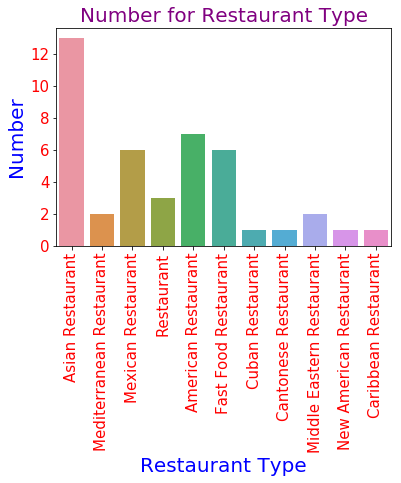

In [45]:
ax = sns.countplot(x='Venue Category',data=lasing_Restaurant)

ax.set_title('Number for Restaurant Type',size=20,color='purple')
ax.set_ylabel('Number',color='blue',size=20)
ax.set_xlabel('Restaurant Type',color='blue',size=20)
ax.set_yticklabels([0,2,4,6,8,10,12], rotation=0,color='red',size=15)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90,color='red',size=15);

### Distribution of Asian restaurant and Non-asian restaurant in each zipcode region 

In [46]:
lansing2 = lasing_Restaurant.groupby('zip').count()
lansing2_merged = lansing2.join(lasing.set_index('zip'),on= 'zip')
lansing2_merged['Population_Per']=lansing2_merged['population']/lansing2_merged['Venue']
lansing2_merged.drop(['zip Latitude','zip Longitude','Venue Category','Venue Latitude','Venue Longitude'],1,inplace=True)
lansing2_merged.reset_index(inplace=True)

In [47]:
lansing2_merged

,zip,Venue,lat,lng,city,population,Population_Per
0,48823,1,42.7620,-84.4539,East Lansing,51302.0,51302.00
1,48824,2,42.7229,-84.4751,East Lansing,1158.0,579.00
2,48825,16,42.7270,-84.4809,East Lansing,12596.0,787.25
3,48842,1,42.6338,-84.5387,Holt,20432.0,20432.00
4,48854,5,42.5820,-84.4517,Mason,18598.0,3719.60
5,48912,5,42.7402,-84.5235,Lansing,17035.0,3407.00
6,48915,2,42.7383,-84.5710,Lansing,9218.0,4609.00
7,48917,1,42.7238,-84.6400,Lansing,32062.0,32062.00
8,48933,10,42.7325,-84.5543,Lansing,2530.0,253.00


Text(0.5,0,'Restaurant Type')

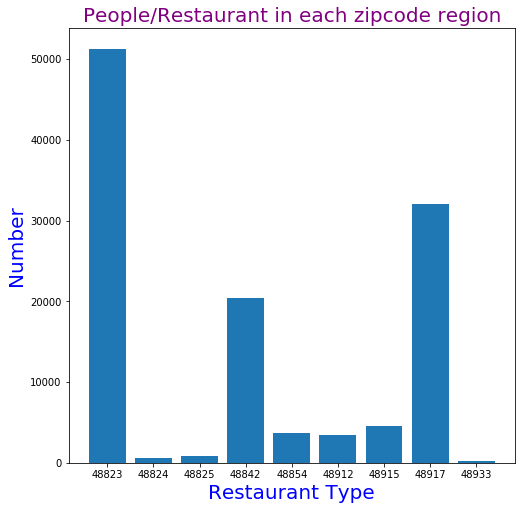

In [48]:

fig, ax = plt.subplots(figsize=(8, 8))
ax.bar(lansing2_merged.zip, lansing2_merged.Population_Per)

ax.set_title('People/Restaurant in each zipcode region',size=20,color='purple')
ax.set_ylabel('Number',color='blue',size=20)
ax.set_xlabel('Restaurant Type',color='blue',size=20);

In [24]:
# one hot encoding
lasing_onehot = pd.get_dummies(lasing_Restaurant[['Venue Category']], prefix="", prefix_sep="")

lasing_onehot['zip'] = lasing_Restaurant['zip'] 

fixed_columns = [lasing_onehot.columns[-1]] + list(lasing_onehot.columns[:-1])
lasing_onehot = lasing_onehot[fixed_columns]

lasing_onehot.head()

,zip,American Restaurant,Asian Restaurant,Cantonese Restaurant,Caribbean Restaurant,Cuban Restaurant,Fast Food Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,New American Restaurant,Restaurant
3,48823,0,1,0,0,0,0,0,0,0,0,0
17,48824,0,1,0,0,0,0,0,0,0,0,0
27,48824,0,0,0,0,0,0,1,0,0,0,0
40,48825,0,0,0,0,0,0,0,1,0,0,0
57,48825,0,1,0,0,0,0,0,0,0,0,0


In [25]:
lasing_grouped = lasing_onehot.groupby('zip').mean().reset_index()
lasing_grouped

,zip,American Restaurant,Asian Restaurant,Cantonese Restaurant,Caribbean Restaurant,Cuban Restaurant,Fast Food Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,New American Restaurant,Restaurant
0,48823,0.0000,1.0,0.0,0.0,0.0,0.0000,0.0000,0.000,0.0,0.0,0.0000
1,48824,0.0000,0.5,0.0,0.0,0.0,0.0000,0.5000,0.000,0.0,0.0,0.0000
2,48825,0.1875,0.5,0.0,0.0,0.0,0.0625,0.0625,0.125,0.0,0.0,0.0625
3,48842,1.0000,0.0,0.0,0.0,0.0,0.0000,0.0000,0.000,0.0,0.0,0.0000
4,48854,0.4000,0.0,0.0,0.0,0.0,0.4000,0.0000,0.200,0.0,0.0,0.0000
5,48912,0.2000,0.2,0.2,0.0,0.2,0.2000,0.0000,0.000,0.0,0.0,0.0000
6,48915,0.0000,0.0,0.0,0.0,0.0,0.0000,0.0000,0.500,0.0,0.0,0.5000
7,48917,0.0000,0.0,0.0,0.0,0.0,1.0000,0.0000,0.000,0.0,0.0,0.0000
8,48933,0.0000,0.2,0.0,0.1,0.0,0.1000,0.0000,0.200,0.2,0.1,0.1000


In [26]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [27]:
num_top_venues = 9

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['zip']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Popular'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Popular'.format(ind+1))

# create a new dataframe
zip_venues_sorted = pd.DataFrame(columns=columns)
zip_venues_sorted['zip'] = lasing_grouped['zip']

for ind in np.arange(lasing_grouped.shape[0]):
    zip_venues_sorted.iloc[ind, 1:] = return_most_common_venues(lasing_grouped.iloc[ind, :], num_top_venues)

zip_venues_sorted

,zip,1st Most Popular,2nd Most Popular,3rd Most Popular,4th Most Popular,5th Most Popular,6th Most Popular,7th Most Popular,8th Most Popular,9th Most Popular
0,48823,Asian Restaurant,Restaurant,New American Restaurant,Middle Eastern Restaurant,Mexican Restaurant,Mediterranean Restaurant,Fast Food Restaurant,Cuban Restaurant,Caribbean Restaurant
1,48824,Mediterranean Restaurant,Asian Restaurant,Restaurant,New American Restaurant,Middle Eastern Restaurant,Mexican Restaurant,Fast Food Restaurant,Cuban Restaurant,Caribbean Restaurant
2,48825,Asian Restaurant,American Restaurant,Mexican Restaurant,Restaurant,Mediterranean Restaurant,Fast Food Restaurant,New American Restaurant,Middle Eastern Restaurant,Cuban Restaurant
3,48842,American Restaurant,Restaurant,New American Restaurant,Middle Eastern Restaurant,Mexican Restaurant,Mediterranean Restaurant,Fast Food Restaurant,Cuban Restaurant,Caribbean Restaurant
4,48854,Fast Food Restaurant,American Restaurant,Mexican Restaurant,Restaurant,New American Restaurant,Middle Eastern Restaurant,Mediterranean Restaurant,Cuban Restaurant,Caribbean Restaurant
5,48912,Fast Food Restaurant,Cuban Restaurant,Cantonese Restaurant,Asian Restaurant,American Restaurant,Restaurant,New American Restaurant,Middle Eastern Restaurant,Mexican Restaurant
6,48915,Restaurant,Mexican Restaurant,New American Restaurant,Middle Eastern Restaurant,Mediterranean Restaurant,Fast Food Restaurant,Cuban Restaurant,Caribbean Restaurant,Cantonese Restaurant
7,48917,Fast Food Restaurant,Restaurant,New American Restaurant,Middle Eastern Restaurant,Mexican Restaurant,Mediterranean Restaurant,Cuban Restaurant,Caribbean Restaurant,Cantonese Restaurant
8,48933,Middle Eastern Restaurant,Mexican Restaurant,Asian Restaurant,Restaurant,New American Restaurant,Fast Food Restaurant,Caribbean Restaurant,Mediterranean Restaurant,Cuban Restaurant


In [28]:
lasing_grouped = lasing_grouped.join(lansing2_merged.set_index('zip'),on= 'zip')
lasing_grouped

,zip,American Restaurant,Asian Restaurant,Cantonese Restaurant,Caribbean Restaurant,Cuban Restaurant,Fast Food Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,New American Restaurant,Restaurant,Venue,lat,lng,city,population,Population_Per
0,48823,0.0000,1.0,0.0,0.0,0.0,0.0000,0.0000,0.000,0.0,0.0,0.0000,1,42.7620,-84.4539,East Lansing,51302.0,51302.00
1,48824,0.0000,0.5,0.0,0.0,0.0,0.0000,0.5000,0.000,0.0,0.0,0.0000,2,42.7229,-84.4751,East Lansing,1158.0,579.00
2,48825,0.1875,0.5,0.0,0.0,0.0,0.0625,0.0625,0.125,0.0,0.0,0.0625,16,42.7270,-84.4809,East Lansing,12596.0,787.25
3,48842,1.0000,0.0,0.0,0.0,0.0,0.0000,0.0000,0.000,0.0,0.0,0.0000,1,42.6338,-84.5387,Holt,20432.0,20432.00
4,48854,0.4000,0.0,0.0,0.0,0.0,0.4000,0.0000,0.200,0.0,0.0,0.0000,5,42.5820,-84.4517,Mason,18598.0,3719.60
5,48912,0.2000,0.2,0.2,0.0,0.2,0.2000,0.0000,0.000,0.0,0.0,0.0000,5,42.7402,-84.5235,Lansing,17035.0,3407.00
6,48915,0.0000,0.0,0.0,0.0,0.0,0.0000,0.0000,0.500,0.0,0.0,0.5000,2,42.7383,-84.5710,Lansing,9218.0,4609.00
7,48917,0.0000,0.0,0.0,0.0,0.0,1.0000,0.0000,0.000,0.0,0.0,0.0000,1,42.7238,-84.6400,Lansing,32062.0,32062.00
8,48933,0.0000,0.2,0.0,0.1,0.0,0.1000,0.0000,0.200,0.2,0.1,0.1000,10,42.7325,-84.5543,Lansing,2530.0,253.00


### Use k-means to cluster those venues 

In [29]:
# set number of clusters
kclusters = 5

lasing_grouped_clustering = lasing_grouped.drop(['zip','Venue','lat','lng','population','city'], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(lasing_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:] 

array([2, 4, 4, 3, 0, 0, 0, 1, 4])

In [30]:
lasing_grouped['Cluster Labels'] = kmeans.labels_
lasing_grouped

,zip,American Restaurant,Asian Restaurant,Cantonese Restaurant,Caribbean Restaurant,Cuban Restaurant,Fast Food Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,New American Restaurant,Restaurant,Venue,lat,lng,city,population,Population_Per,Cluster Labels
0,48823,0.0000,1.0,0.0,0.0,0.0,0.0000,0.0000,0.000,0.0,0.0,0.0000,1,42.7620,-84.4539,East Lansing,51302.0,51302.00,2
1,48824,0.0000,0.5,0.0,0.0,0.0,0.0000,0.5000,0.000,0.0,0.0,0.0000,2,42.7229,-84.4751,East Lansing,1158.0,579.00,4
2,48825,0.1875,0.5,0.0,0.0,0.0,0.0625,0.0625,0.125,0.0,0.0,0.0625,16,42.7270,-84.4809,East Lansing,12596.0,787.25,4
3,48842,1.0000,0.0,0.0,0.0,0.0,0.0000,0.0000,0.000,0.0,0.0,0.0000,1,42.6338,-84.5387,Holt,20432.0,20432.00,3
4,48854,0.4000,0.0,0.0,0.0,0.0,0.4000,0.0000,0.200,0.0,0.0,0.0000,5,42.5820,-84.4517,Mason,18598.0,3719.60,0
5,48912,0.2000,0.2,0.2,0.0,0.2,0.2000,0.0000,0.000,0.0,0.0,0.0000,5,42.7402,-84.5235,Lansing,17035.0,3407.00,0
6,48915,0.0000,0.0,0.0,0.0,0.0,0.0000,0.0000,0.500,0.0,0.0,0.5000,2,42.7383,-84.5710,Lansing,9218.0,4609.00,0
7,48917,0.0000,0.0,0.0,0.0,0.0,1.0000,0.0000,0.000,0.0,0.0,0.0000,1,42.7238,-84.6400,Lansing,32062.0,32062.00,1
8,48933,0.0000,0.2,0.0,0.1,0.0,0.1000,0.0000,0.200,0.2,0.1,0.1000,10,42.7325,-84.5543,Lansing,2530.0,253.00,4


In [32]:
cluster_region1=lasing_grouped[['zip','Cluster Labels']]
cluster_region2=zip_venues_sorted[['zip','1st Most Popular']]
cluster_region = cluster_region1.join(cluster_region2.set_index('zip'),on= 'zip')
cluster_region

,zip,Cluster Labels,1st Most Popular
0,48823,2,Asian Restaurant
1,48824,4,Mediterranean Restaurant
2,48825,4,Asian Restaurant
3,48842,3,American Restaurant
4,48854,0,Fast Food Restaurant
5,48912,0,Fast Food Restaurant
6,48915,0,Restaurant
7,48917,1,Fast Food Restaurant
8,48933,4,Middle Eastern Restaurant


In [40]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(lasing_grouped['lat'], lasing_grouped['lng'], lasing_grouped['zip'], lasing_grouped['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)


map_clusters

# Conclusion
People in **Cluster 2** region like Asian food. The most popular restaurant is Asian Restaurant. So cluster 2 region is an good place to operate a Asian restaurant.

In [39]:
Asian_restaurant = lasing_grouped.loc[lasing_grouped['Cluster Labels'] == 2]

In [41]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Asian_restaurant['lat'], Asian_restaurant['lng'], Asian_restaurant['zip'], Asian_restaurant['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7).add_to(map_clusters)
folium.CircleMarker([42.762,-84.4539],radius=10,color='yellow').add_to(map_clusters)    
map_clusters

##   The best place to open an Asian Restaurant is at 48823 region.